In [84]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Motivation

Check whether certain selective cell types contribute specifically to stimulus coding.

In [85]:
# Import generic libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import scipy.io
import os, sys
import tqdm
from scipy.optimize import curve_fit
from pathlib import Path
import pickle

In [86]:
# Import local tools

sys.path.append(os.path.expanduser('~/Desktop/Analysis/kohl-lab-pynalysis/'))

from pynalysis import utils

In [87]:
# Import local OASIS installation
sys.path.append(os.path.expanduser('~/Desktop/Analysis/OASIS-master/'))
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis import oasisAR1, oasisAR2

In [88]:
# Set file-name and path to analyze
stringid = "CTBD2.5d"
filename = os.path.expanduser('~/Desktop/2p_data/df-structures/imaging/%s.mat'%stringid)

In [89]:
# Load data struct
dat = utils.load_mat_file(filename)

Not an old MAT struct. Trying to read as HDF5 for MATLAB v7.3 format instead


In [90]:
# Print contents
print("subject: %s"%stringid)
utils.print_file_content(dat)

subject: CTBD2.5d
imaging/
 date_2018_11_13
 ->area1 ['plane1', 'plane2', 'session_behaviour']
 ->area2 ['plane1', 'plane2', 'session_behaviour']
 date_2018_11_25
 ->area1 ['session_behaviour']
 date_2018_11_26
 ->area1 ['session_behaviour']
 date_2018_11_27
 ->area1 ['plane1', 'plane2', 'session_behaviour']
 ->area2 ['plane1', 'plane2', 'session_behaviour']
 ->area3 ['session_behaviour']
 date_2018_11_28
 ->area1 ['session_behaviour']
 date_2018_11_29
 ->area1 ['session_behaviour']
 date_2018_12_01
 ->area1 ['session_behaviour']
 date_2018_12_03
 ->area1 ['session_behaviour']
 date_2018_12_04
 ->area1 ['session_behaviour']
 date_2018_12_05
 ->area1 ['session_behaviour']
 date_2018_12_06
 ->area1 ['session_behaviour']
 date_2018_12_07
 ->area1 ['session_behaviour']
 ->area2 ['session_behaviour']
 date_2018_12_08
 ->area1 ['plane1', 'plane2', 'session_behaviour']
 ->area2 ['plane1', 'plane2', 'session_behaviour']
 date_2018_12_09
 ->area1 ['plane1', 'plane2', 'session_behaviour']
 ->are

In [91]:
### Select dataset to analyze
area_name = "area2"
date="date_2018_12_19"
expspecifier = "%s/%s"%(date,area_name)
path="imaging/%s"%expspecifier
area=dat.get(path)
utils.get_hdf5group_keys(area)

['plane1', 'plane2', 'session_behaviour']

In [92]:
print("%s/%s"%(stringid,expspecifier))

CTBD2.5d/date_2018_12_19/area2


In [93]:
plane1=area['plane1']
plane2=area['plane2']
sessbehav=area['session_behaviour']

In [94]:
# Check how many unit are in each plane
print(plane1['fluoresence_corrected'].shape[1])
print(plane2['fluoresence_corrected'].shape[1])

44
11


In [95]:
print(utils.get_hdf5group_keys(plane1))

['fRate', 'fluoresence_corrected', 'info', 'is_red', 'position', 'raw_fluoresence', 'raw_neuropil', 'spike_amps', 'spike_timings', 'trialByTrialAmps', 'trialByTrialFlu', 'trialByTrialSpikes']


In [96]:
# Extract frame rate from struct
frate = area['plane1/fRate'][0,0]
print("Frame rate %f"%frate)

Frame rate 15.020000


In [97]:
# Merge fluorescence corrected from multiple planes
fluo_raw = np.concatenate([plane1['fluoresence_corrected'], plane2['fluoresence_corrected']],axis=1).T
time = np.arange(len(fluo_raw.T))*1.0/frate

In [98]:
fluo_raw.shape

(55, 25000)

In [99]:
# Select traces below saturation
fidx=fluo_raw.max(1)<6000

In [100]:
fluo = fluo_raw[fidx]
print(fluo.shape)

(55, 25000)


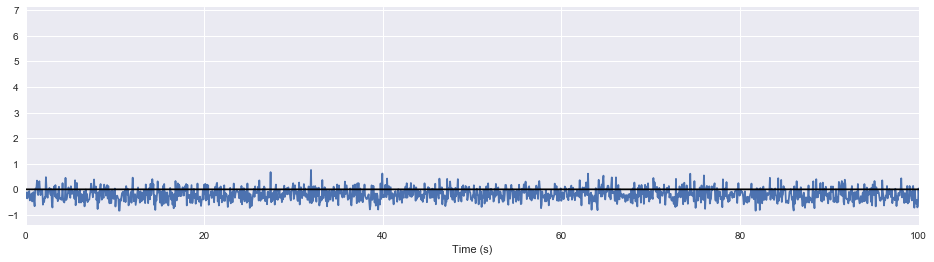

In [101]:
sample_id = 5
plt.figure(figsize=(16,4))
time = np.arange(len(fluo_raw.T))*1.0/frate
p0 = plt.plot(time, fluo[sample_id].T)
# p0 = plt.plot(time, traces[sample_id].T)
p0=plt.plot(time, np.zeros(time.shape), color='black')
plt.xlabel("Time (s)")
plt.xlim(0,100)
sns.despine()

In [102]:
# Extract positions
tmp = []
for pos in plane1['position']:
    tmp.append(pos)
positions_plane1 = np.array(tmp).T

tmp = []
for pos in plane2['position']:
    tmp.append(pos)
positions_plane2 = np.array(tmp).T

positions_pivot = len(positions_plane1)

In [103]:
print(utils.get_hdf5group_keys(sessbehav))

['ID', 'TTLs', 'area', 'area1', 'date', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'stim_speed', 'task', 'velocity']


In [104]:
# Extract event timing
motor_events = ['motor_start', 'motor_back', 'motor_atWhisk']
event_fields = []
event_fields.extend(motor_events)
event_fields.extend(['velocity', 'stim_speed', 'stim_position'])
# event_fields = ['motor_start']

events = {}
for f in event_fields:
    events[f] = np.array(sessbehav[f])
t_stim = events['motor_start']

# discard last events if necessary
events['motor_start'] = events['motor_start']#[:-2]
events['motor_atWhisk'] = events['motor_atWhisk']
events['stim_position'] = events['stim_position']#[:-2]
events['stim_speed'] = events['stim_speed']#[:-2]

In [105]:
#check how many events 
np.shape(events['motor_start'])


(206, 1)

In [106]:
np.shape(events['motor_atWhisk'])

(206, 1)

In [107]:
np.shape(events['stim_position'])

(206, 1)

In [108]:
np.shape(events['stim_speed'])

(206, 1)

In [109]:
np.shape(events['motor_back'])

(206, 1)

In [110]:
# select only fast events
sel=events['stim_speed']==840

In [111]:
# events['motor_start'] = events['motor_start'][sel]
# events['motor_atWhisk'] = events['motor_atWhisk'][sel]
# events['stim_position'] = events['stim_position'][sel]
# events['stim_speed'] = events['stim_speed'][sel]

# Preprocessing

In [112]:
events.keys()

dict_keys(['motor_start', 'motor_back', 'motor_atWhisk', 'velocity', 'stim_speed', 'stim_position'])

In [113]:
def plot_trace(groundtruth=False):
    plt.figure(figsize=(20,4))
    plt.subplot(211)
    plt.plot(b+c, lw=2, label='denoised')
    if groundtruth:
        plt.plot(true_b+true_c, c='r', label='truth', zorder=-11)
    plt.plot(y, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))
    # simpleaxis(plt.gca())
    plt.subplot(212)
    plt.plot(s, lw=2, label='deconvolved', c='g')
    if groundtruth:
        for k in np.where(true_s)[0]:
            plt.plot([k,k],[-.1,1], c='r', zorder=-11, clip_on=False)
    plt.ylim(0,1.3)
    plt.legend(ncol=3, frameon=False, loc=(.02,.85));
    # simpleaxis(plt.gca())
    print("Correlation of deconvolved activity  with ground truth ('spikes') : %.4f" % np.corrcoef(s,true_s)[0,1])
    print("Correlation of denoised fluorescence with ground truth ('calcium'): %.4f" % np.corrcoef(c,true_c)[0,1])

In [114]:
# Init values for OASIS

# take taus from here: https://github.com/MouseLand/suite2p/wiki/Settings-(ops.npy)
#tau_d = 270e-3 # GCAMP6M
# tau_d = 142e-3 # GCAMP6F
tau_d = 1250e-3 # GCAMP6s

ginit = (np.exp(-1.0/(frate*tau_d)),)
ginit = (None,)
# ginit=(None,) # Single exponential, fit time constant
# ginit = (0.70,) # Single exponential, fix time constant
print(ginit)

(None,)


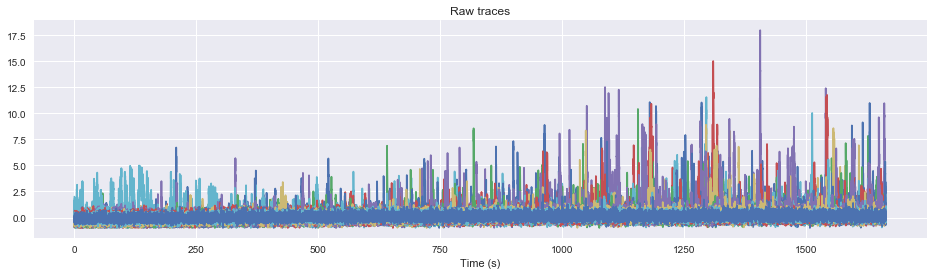

In [115]:
plt.figure(figsize=(16,4))
p0 = plt.plot(time, fluo.T)
# p1 = plt.scatter(stim.running_forward*1e-3,7*np.ones(len(stim.running_forward)), color='blue', label='Running fwd.')
plt.title("Raw traces")
plt.xlabel("Time (s)")
# plt.ylim(0,1)
sns.despine()

In [116]:
# Run OASIS on each fluorescence trace
traces = []
ret_values = []
for idx in tqdm.trange(len(fluo)):
# for idx in tqdm.trange(10):
    y = np.array(fluo[idx],dtype=float)
    c, s, b, g, lam = r = deconvolve(y, g=ginit, penalty=1)
    traces.append(c)
    # print(g)
    ret_values.append(r)
traces = np.array(traces)

100%|██████████| 55/55 [00:00<00:00, 57.11it/s]


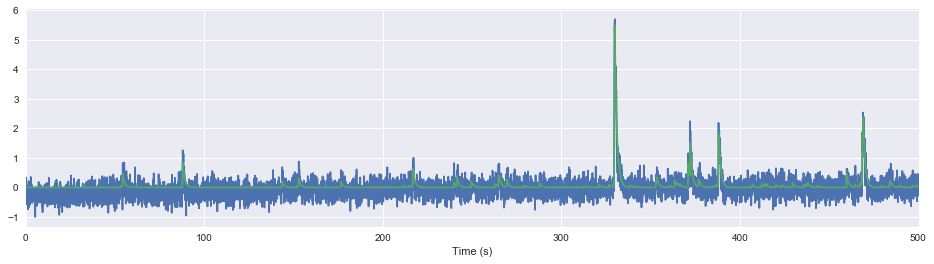

In [117]:
sample_id = 3
smp = ret_values[sample_id]
plt.figure(figsize=(16,4))
p0=plt.plot(time, fluo[sample_id].T)
p0=plt.plot(time, smp[0].T+smp[2])
plt.xlabel("Time (s)")
plt.xlim(0,500)
sns.despine()

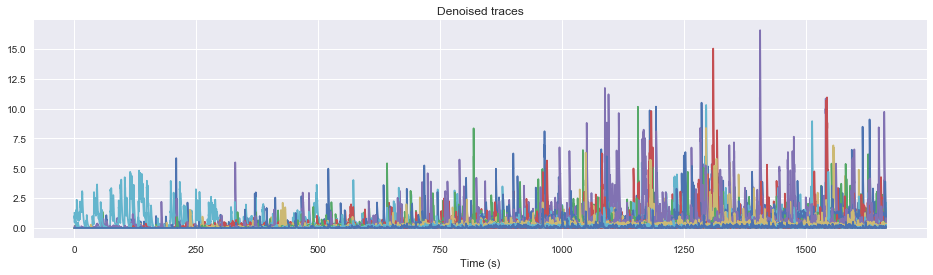

In [118]:
plt.figure(figsize=(16,4))
p0 = plt.plot(time, traces.T)
# p1 = plt.scatter(stim.running_forward*1e-3,7*np.ones(len(stim.running_forward)), color='blue', label='Running fwd.')
plt.xlabel("Time (s)")
plt.title("Denoised traces")
sns.despine()

# Sanity checks

##  A look at effective data dimension with PCA

In [119]:
from sklearn.decomposition import PCA, NMF, FastICA
nb_components = 60

In [120]:
X = np.array(traces.T)

pca = PCA()
pca.fit(X)
varexp_denoised = np.cumsum(pca.explained_variance_ratio_)

In [121]:
X = np.array(fluo.T)
time = np.arange(len(X))*1.0/frate
pca = PCA()
pca.fit(X)
varexp_raw = np.cumsum(pca.explained_variance_ratio_)

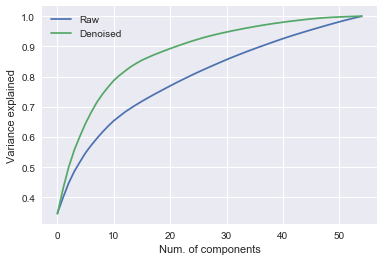

In [122]:
plt.plot(varexp_raw, label="Raw")
plt.plot(varexp_denoised, label="Denoised")
plt.legend()
plt.xlabel("Num. of components")
plt.ylabel("Variance explained")

# Trial binning of data

In [123]:
def datamatrix2tensor(data, event_times, toff_after, toff_before=0):
    """ Slices flat data matrix into trial based tensor.
    
    Expects data to be time x unit.
    
    Returns: A tensor which is trial x time x unit.
    """
    trials = []
    nb_frames = data.shape[0]
    for ev in event_times:
        fr = int(ev)
        if fr<toff_before or fr>nb_frames-toff_after: continue
        s = data[fr-toff_before:fr+toff_after]
        trials.append(s)
    return np.array(trials)

In [124]:
def tensorbin(data, bin_size=10):
    """ Takes data tensor and bins it """
    nb_bins = data.shape[1]//bin_size
    #print(data.shape)
    binned = []
    for i in range(nb_bins):
        a = data[:,i*bin_size:(i+1)*bin_size,:]
        # print(a.shape)
        binned.append(np.sum(a,axis=1))
    return np.transpose(np.array(binned),axes=[1,0,2])
    
def bin_data(data, event_times, toff_after=60, toff_before=0, bin_size=10, axis=1):
    datatensor = datamatrix2tensor(data,event_times,toff_before=toff_before, toff_after=toff_after)
    #     return datatensor.mean(axis=axis)
    return tensorbin(datatensor, bin_size)

# Decoding stimulus from neural data using SVM Classifier

In [125]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.preprocessing

In [126]:
def split_dataset(dataset, split=0.8, shuffle=True):
    x,y = dataset
    n = len(x)
    s = int(split*n)
    idx = np.arange(len(x))
    if shuffle: np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    x_train = x[:s]
    x_valid = x[s:]
    y_train = y[:s]
    y_valid = y[s:]
    return (x_train, y_train),(x_valid, y_valid)

In [127]:
def fuse_dataset(data, labels, standardize=True):
    d = data.reshape((data.shape[0],-1))
    if standardize:
        scaler = sklearn.preprocessing.Normalizer()
        d = scaler.fit_transform(d)
    return d,labels

In [128]:
def get_acc(dataset):
    pred=svc.predict(dataset[0])
    acc=(pred==dataset[1]).mean()
    return acc

In [129]:
def get_acc_all_times(all_data, labels, units="all", kernel="linear"):
    """ Fits SVC on each time slice from datatensor
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    
    Returns classification accuracy scores for 5-fold CV of a linear classifer.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    dataset = fuse_dataset(data_selection,labels)
    clf = SVC(kernel=kernel, C=1)
    scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
    return scores



def scan_acc_time(all_data, labels, units="all", kernel="linear"):
    """ Fits SVC on each time slice from datatensor
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    
    Returns classification accuracy scores for 5-fold CV of a linear classifer over time.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    results = []
    for t in range(data_selection.shape[1]):
        partial_data = data_selection[:,t,:]
        dataset = fuse_dataset(partial_data,labels)
        clf = SVC(kernel=kernel, C=1)
        scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
        results.append(scores)
    results = np.array(results)
    return results

In [130]:
def cyclic_split_dataset(dataset, split=0.8, splitid=0):
    x,y = dataset
    n = len(x)
    s = int(split*n)
    k = splitid
    # split data cyclically
    o = int((1.0-split)*n)
    if (1.0-split)*k>1.0:
        print("Cannot have more than %i different cyclic splits."%(1.0/(1.0-split)))
        raise ValueError
    x_train = np.concatenate( [x[:k*o], x[(k+1)*o:]], axis=0 )
    x_valid = x[k*o:(k+1)*o]
    y_train = np.concatenate( [y[:k*o], y[(k+1)*o:]], axis=0 )
    y_valid = y[k*o:(k+1)*o]
    return (x_train, y_train),(x_valid, y_valid)

def get_trial_predictions(all_data, labels, units="all", kernel="linear", splitid=0):
    """ Fits SVC on trials and returns array for correct trials==True for validation set
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    dataset = fuse_dataset(data_selection,labels)
    train,test = cyclic_split_dataset(dataset, splitid=splitid)
    clf = SVC(kernel=kernel, C=1)
    clf.fit(*train)
    pred=clf.predict(test[0])
    acc=(pred==test[1]).mean()
    print(acc)
    return clf.predict(test[0])==test[1]

In [131]:
# How many frames before and after the onset signal we use for classification
frames_before = 30
frames_after  = 30

# Create data tensor from denoised traces for all trials
full_data = datamatrix2tensor(traces.T, events['motor_atWhisk'], toff_before=frames_before, toff_after=frames_after)
print("Datatensor shape: ",full_data.shape)

# Creat labels for data
labels = stim_pos = events['stim_position'].ravel()
print("Unique labels: ",np.unique(labels))

Datatensor shape:  (206, 60, 55)
Unique labels:  [ 35.  42.  49.  56.  63.  70.]


In [132]:
vel = events['velocity'].ravel()
run_data = datamatrix2tensor(vel, events['motor_atWhisk'], toff_before=frames_before, toff_after=frames_after)

In [133]:
run_data = run_data.mean(1)

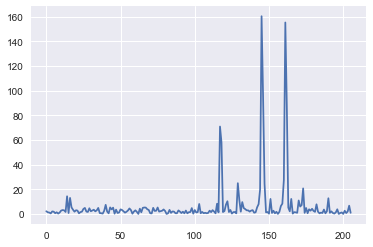

In [134]:
plt.plot(run_data)

# Leave some out analysis un subsets of cells

In [135]:
# Do the same analysis for each plane separately
nb_plane1 = plane1['fluoresence_corrected'].shape[1]
nb_plane2 = plane2['fluoresence_corrected'].shape[1]

In [136]:
mean_performance = {}

In [137]:
print("%s/%s"%(stringid,expspecifier))

CTBD2.5d/date_2018_12_19/area2


In [138]:
nb_plane1

44

In [139]:
def get_leave_some_out_performance(units, nb_repeats=10):
    """ Compute the summary performance curve for arbitrary subsets of units.
    
    Args:
    units : a list of units to run the anlaysis on
    
    Returns : a dictionary in which keys are the fractions of units used in the analysis which contains 
                tuples with mean and stdev.
    """
    n = len(units)
    mean_performance = {}
    for frac in np.linspace(0.1,1,10):
        m = int(frac*n)
        if not m: continue
        print("frac=%.2f, nb_units=%i"%(frac,m))
        results_subsets = []
        total_acc_subsets = []
        for r in range(nb_repeats):
            idx = list(units)
            np.random.shuffle(idx)
            idx = idx[:m]
            res = scan_acc_time(full_data, labels, kernel=kernel, units=idx)
            results_subsets.append(res)
            acc = get_acc_all_times(full_data, labels, units=idx)
            total_acc_subsets.append(acc)

        means = [ acc.mean() for acc in total_acc_subsets]
        stds = [ acc.std() for acc in total_acc_subsets]
        
        omean = np.array(means).mean() # overall mean
        # ostdev = np.sqrt((np.array(stds)**2).sum()/m)
        ostdev = np.array(stds).mean()
    
        mean_performance[frac] = dict(mean=omean, stdev=ostdev, nb_units=m)
    return mean_performance

In [140]:
def get_list_of_units_from_cat(select_category, cat_array, add_unit_offset=0):
    return list(np.argwhere(cat_array==select_category)[:,0]+add_unit_offset)

In [141]:
resp_file_load=os.path.expanduser('~/Desktop/Results/tuning_data/%s_RvsNR_tuning.mat'%stringid)

resp_file=utils.load_mat_file(resp_file_load)

Not an old MAT struct. Trying to read as HDF5 for MATLAB v7.3 format instead


In [142]:
# define resp and non-resp neurons for plane 1
plane1_cats=resp_file.get('tuning_all/%s/%s/plane1'%(date,area_name))
utils.get_hdf5group_keys(plane1_cats)

goodrois_p1=np.array(plane1_cats['good_rois'])

goodrois_p1_idx=get_list_of_units_from_cat(1,goodrois_p1)
badrois_p1_idx=get_list_of_units_from_cat(0,goodrois_p1)

print(goodrois_p1_idx)
print(badrois_p1_idx)


[1, 3, 10, 11, 12, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 36, 43]
[0, 2, 4, 5, 6, 7, 8, 9, 13, 19, 20, 21, 27, 28, 34, 35, 37, 38, 39, 40, 41, 42]


In [143]:
# define resp and non-resp neurons for plane 2

plane2_cats=resp_file.get('tuning_all/%s/%s/plane2'%(date,area_name))
utils.get_hdf5group_keys(plane2_cats)

goodrois_p2=np.array(plane2_cats['good_rois'])

goodrois_p2_idx=get_list_of_units_from_cat(1,goodrois_p2)
badrois_p2_idx=get_list_of_units_from_cat(0,goodrois_p2)

print(goodrois_p2_idx)
print(badrois_p2_idx)


[0, 1, 4, 5, 8, 10]
[2, 3, 6, 7, 9]


In [144]:
# Compute classification accuracy for each time bin
kernel = "poly"
results_all = scan_acc_time(full_data, labels, kernel=kernel)

# Compute classification accuracy for all time bins together
acc_total = get_acc_all_times(full_data, labels)
print(acc_total.mean(),acc_total.std())

0.326411611644 0.0673542361696


In [145]:
#classifier for 2 planes together. all neurons (or random subsets)

#perfs = [ get_leave_some_out_performance(u) for u in [range(nb_plane1+nb_plane2)] ] 

In [146]:
#classifier for plane2 all neurons (or random subsets)

perfs_p2 = [ get_leave_some_out_performance(u) for u in [range(nb_plane1, nb_plane1+nb_plane2)] ] 

frac=0.10, nb_units=1
frac=0.20, nb_units=2
frac=0.30, nb_units=3
frac=0.40, nb_units=4
frac=0.50, nb_units=5
frac=0.60, nb_units=6
frac=0.70, nb_units=7
frac=0.80, nb_units=8
frac=0.90, nb_units=9
frac=1.00, nb_units=11


In [147]:
#classifier for plane1 all neurons (or random subsets)
perfs_p1 = [ get_leave_some_out_performance(u) for u in [range(nb_plane1)] ] 

frac=0.10, nb_units=4
frac=0.20, nb_units=8
frac=0.30, nb_units=13
frac=0.40, nb_units=17
frac=0.50, nb_units=22
frac=0.60, nb_units=26
frac=0.70, nb_units=30
frac=0.80, nb_units=35
frac=0.90, nb_units=39
frac=1.00, nb_units=44


In [148]:
perfs_good_p1 = [ get_leave_some_out_performance(u) for u in [goodrois_p1_idx] ] 
perfs_bad_p1 = [ get_leave_some_out_performance(u) for u in [badrois_p1_idx] ] 

frac=0.10, nb_units=2
frac=0.20, nb_units=4
frac=0.30, nb_units=6
frac=0.40, nb_units=8
frac=0.50, nb_units=11
frac=0.60, nb_units=13
frac=0.70, nb_units=15
frac=0.80, nb_units=17
frac=0.90, nb_units=19
frac=1.00, nb_units=22
frac=0.10, nb_units=2
frac=0.20, nb_units=4
frac=0.30, nb_units=6
frac=0.40, nb_units=8
frac=0.50, nb_units=11
frac=0.60, nb_units=13
frac=0.70, nb_units=15
frac=0.80, nb_units=17
frac=0.90, nb_units=19
frac=1.00, nb_units=22


In [149]:
perfs_good_p2 = [ get_leave_some_out_performance(u) for u in [goodrois_p2_idx] ] 
perfs_bad_p2 = [ get_leave_some_out_performance(u) for u in [badrois_p2_idx] ] 

frac=0.20, nb_units=1
frac=0.30, nb_units=1
frac=0.40, nb_units=2
frac=0.50, nb_units=3
frac=0.60, nb_units=3
frac=0.70, nb_units=4
frac=0.80, nb_units=4
frac=0.90, nb_units=5
frac=1.00, nb_units=6
frac=0.20, nb_units=1
frac=0.30, nb_units=1
frac=0.40, nb_units=2
frac=0.50, nb_units=2
frac=0.60, nb_units=3
frac=0.70, nb_units=3
frac=0.80, nb_units=4
frac=0.90, nb_units=4
frac=1.00, nb_units=5


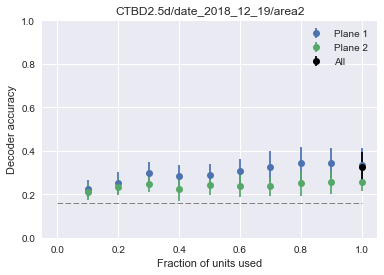

In [150]:
#plots for all neurons, different planes
def plot_mperf_vs_frac(mperf, **kwargs):
    x = []
    y = []
    dy = []
    for k in mperf.keys():
        dat = mperf[k]
        x.append(k)
        a = dat['mean']
        b = dat['stdev']
        y.append(a)
        dy.append(b)
    plt.errorbar(x,y,yerr=dy, ls='None', fmt='o', **kwargs)

    
#for i,perf in enumerate(perfs):
   #plot_mperf_vs_frac(perf,label='All cells')
for i,perf in enumerate(perfs_p1):
   plot_mperf_vs_frac(perf, label='Plane 1')
for i,perf in enumerate(perfs_p2):
   plot_mperf_vs_frac(perf, label = 'Plane 2')
    
    
# plot_mperf_vs_frac(perf_plane2, label="Plane2")
plt.errorbar([1.0],[acc_total.mean()],yerr=[acc_total.std()], ls='None', fmt='o', color="k", label="All")
plt.xlabel("Fraction of units used")
plt.ylabel("Decoder accuracy")
plt.legend()
plt.ylim((0,1))
plt.plot([0,1], [0.16,0.16], color='gray', linestyle='--', linewidth=1)
plt.title("%s/%s"%(stringid,expspecifier))
sns.despine()
plt.savefig("leave_some_out_summary_frac_%s_%s_%s.svg"%(stringid,area_name,date))


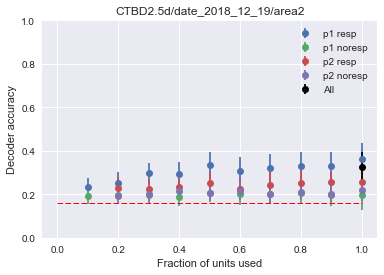

In [151]:
#plots for responsive or bad neurons, different planes
def plot_mperf_vs_frac(mperf, **kwargs):
    x = []
    y = []
    dy = []
    for k in mperf.keys():
        dat = mperf[k]
        x.append(k)
        a = dat['mean']
        b = dat['stdev']
        y.append(a)
        dy.append(b)
    plt.errorbar(x,y,yerr=dy, ls='None', fmt='o', **kwargs)

    
for i,perf in enumerate(perfs_good_p1):
   plot_mperf_vs_frac(perf,label='p1 resp')
for i,perf in enumerate(perfs_bad_p1):
   plot_mperf_vs_frac(perf, label='p1 noresp')
for i,perf in enumerate(perfs_good_p2):
   plot_mperf_vs_frac(perf, label = 'p2 resp')
for i,perf in enumerate(perfs_bad_p2):
   plot_mperf_vs_frac(perf, label='p2 noresp')
    
    
# plot_mperf_vs_frac(perf_plane2, label="Plane2")
plt.errorbar([1.0],[acc_total.mean()],yerr=[acc_total.std()], ls='None', fmt='o', color="k", label="All")
plt.xlabel("Fraction of units used")
plt.ylabel("Decoder accuracy")
plt.legend()
plt.ylim((0,1))
plt.plot([0,1], [0.16,0.16], color='red', linestyle='--', linewidth=1)
plt.title("%s/%s"%(stringid,expspecifier))
sns.despine()
plt.savefig("leave_some_out_good_and_bad_%s_%s_%s.svg"%(stringid,area_name,date))

In [152]:
# don't run after this!

In [153]:
# redo analysis for random subsets of m neurons
#frac=1
#catid = 3
## print("nb_units=%i"%m)
#results_subsets = []
#total_acc_subsets = []
#for r in range(10):
    #idx = list(units[catid])
    #np.random.shuffle(idx)
    #n = len(idx)
    #m = int(frac*n)
    #idx = idx[:m]
    #res = scan_acc_time(full_data, labels, kernel=kernel, units=idx)
    ##results_subsets.append(res)
    ##acc = get_acc_all_times(full_data, labels, units=idx)
    ##total_acc_subsets.append(acc)

In [154]:
# x = np.linspace(-frames_before/frate,frames_after/frate,full_data.shape[1])
# def plot_res(x, results, **kwargs):
#     means = results.mean(1)
#     stdev = results.std(1)
#     return plt.errorbar(x, means, yerr=stdev, **kwargs)

# for i,res in enumerate(results_subsets):
#     plot_res(x, res, label="Set%i"%i)
# plot_res(x, results_all, label="All", color='black')


# m,s=acc_total.mean(),acc_total.std()
# plt.plot([x[0], x[-1]], [m, m], color='gray', linestyle='--', linewidth=2)
# plt.xlabel('Time (s)')
# plt.ylabel('Accuracy')
# plt.legend(loc='best')
# plt.title("%s, fraction analyzed %.2f"%(cat_names[catid],frac))
# sns.despine()

In [155]:
# m = len(total_acc_subsets)
# ind = range(m)
# width = 0.8
# means = [ acc.mean() for acc in total_acc_subsets]
# stds = [ acc.std() for acc in total_acc_subsets]
# omean = np.array(means).mean() # overall mean
# ostdev = np.sqrt((np.array(stds)**2).sum()/m) # overall stdev 
# # TODO: check if m should be outside of sqrt, probably not, but just ot make sure
# rects_all = plt.bar([-2], [acc_total.mean()], width,
#                 color='black',
#                 yerr=[acc_total.std()], label="All")
# rects_avg = plt.bar([-1], [omean], width,
#                 color='red',
#                 yerr=[ostdev], label="SubsetAvg")
# rects1 = plt.bar(ind, means, width,
#                 color='gray',
#                 yerr=stds, label="Subset")
# plt.plot([0,10],[0.25,0.25],label="Chance",color="black",ls="--")
# plt.title("Fraction analyzed %.2f"%frac)
# plt.xlabel("Repeats")
# plt.ylabel("Accuracy")
# plt.legend(loc='lower right')
# sns.despine()

In [156]:
#mean_performance[frac] = (omean, ostdev) 

In [157]:
#print(mean_performance)

In [158]:
# x = []
# y = []
# dy = []
# for k in mean_performance.keys():
#     x.append(k)
#     a,b = mean_performance[k]
#     y.append(a)
#     dy.append(b)
    
# # plt.errorbar?
# plt.errorbar(x,y,yerr=dy, ls='None', fmt='o')
# plt.errorbar([1.0],[acc_total.mean()],yerr=[acc_total.std()], ls='None', fmt='o', color="k")
# plt.xlabel("Fraction analyzed")
# plt.ylabel("Decoder accuracy")
# sns.despine()
# plt.savefig("leave_some_out_summary.pdf")

In [159]:
# print(1/0) # there be dragons

# Leave some out analysis on individual planes (plane1)

In [160]:
# def get_leave_some_out_performance(units, nb_repeats=10):
#     """ Compute the summary performance curve for arbitrary subsets of units.
    
#     Args:
#     units : a list of units to run the anlaysis on
    
#     Returns : a dictionary in which keys are the fractions of units used in the analysis which contains 
#                 tuples with mean and stdev.
#     """
#     n = len(units)
#     mean_performance = {}
#     for frac in np.linspace(0.1,0.9,9):
#         m = int(frac*n)
#         print("frac=%.2f, nb_units=%i"%(frac,m))
#         results_subsets = []
#         total_acc_subsets = []
#         for r in range(nb_repeats):
#             idx = list(units)
#             np.random.shuffle(idx)
#             idx = idx[:m]
#             res = scan_acc_time(full_data, labels, kernel=kernel, units=idx)
#             results_subsets.append(res)
#             acc = get_acc_all_times(full_data, labels, units=idx)
#             total_acc_subsets.append(acc)

#         means = [ acc.mean() for acc in total_acc_subsets]
#         stds = [ acc.std() for acc in total_acc_subsets]
#         omean = np.array(means).mean() # overall mean
#         ostdev = np.sqrt((np.array(stds)**2).sum()/m)
    
#         mean_performance[frac] = dict(mean=omean, stdev=ostdev, nb_units=m)
#     return mean_performance

In [161]:
# units = list(range(nb_plane1+nb_plane2)) # select all neurons from both planes
# perf_both = get_leave_some_out_performance(units)

In [162]:
# units = list(range(0,nb_plane1)) # select neurons from Plane1
# perf_plane1 = get_leave_some_out_performance(units)

In [163]:
# units = list(np.arange(0,nb_plane2)+nb_plane1) # select neurons from Plane2
# perf_plane2 = get_leave_some_out_performance(units)

In [164]:
# def plot_mperf_vs_frac(mperf, **kwargs):
#     x = []
#     y = []
#     dy = []
#     for k in mperf.keys():
#         dat = mperf[k]
#         x.append(k)
#         a = dat['mean']
#         b = dat['stdev']
#         y.append(a)
#         dy.append(b)
#     plt.errorbar(x,y,yerr=dy, ls='None', fmt='o', **kwargs)

    
# plot_mperf_vs_frac(perf_plane1, label="Plane1")
# plot_mperf_vs_frac(perf_plane2, label="Plane2")
# plt.errorbar([1.0],[acc_total.mean()],yerr=[acc_total.std()], ls='None', fmt='o', color="k", label="All")
# plt.xlabel("Fraction of units used")
# plt.ylabel("Decoder accuracy")
# plt.legend()
# plt.title("%s/%s"%(stringid,expspecifier))
# sns.despine()
# plt.savefig("leave_some_out_summary_frac.pdf")

In [165]:
# def plot_mperf_vs_nbunits(mperf, **kwargs):
#     x = []
#     y = []
#     dy = []
#     for k in mperf.keys():
#         dat = mperf[k]
#         x.append(dat['nb_units'])
#         a = dat['mean']
#         b = dat['stdev']
#         y.append(a)
#         dy.append(b)
#     plt.errorbar(x,y,yerr=dy, ls='None', fmt='o', **kwargs)
    
# plot_mperf_vs_nbunits(perf_plane1, label="Plane1")
# plot_mperf_vs_nbunits(perf_plane2, label="Plane2")
# plt.errorbar([nb_plane1+nb_plane2],[acc_total.mean()],yerr=[acc_total.std()], ls='None', fmt='o', color="k", label="All")
# plt.xlabel("Number of units used")
# plt.ylabel("Decoder accuracy")
# plt.legend()
# plt.title("%s/%s"%(stringid,expspecifier))
# sns.despine()
# plt.savefig("leave_some_out_summary_num.pdf")

In [166]:
#print(perf_plane1)